In [47]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [48]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [49]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

In [51]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [52]:
train_set.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

In [53]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "name": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [54]:
for image, label in train_set.take(1):
    an_example = create_example(image, label)
an_example

features {
  feature {
    key: "name"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000<yJ55,w\200\022\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000-\206\311\277\322\347\364\371\367\356\304\333\313\216\034\000\000\000\000\000\000\000\000\000\000\000\000\222\313\311\277\274\264\260\266\271\273\257\264\271\276\306\301<\000\000\000\000\000\000\000\000\000\000L\322\276\274\277\301\302\275\266\270\271\274\273\271\271\264\277\252\000\000\000\000\000\000\000\000\000\000\240\310\302\303\277\303\301\274\273\276\267\270\271\271\271\270\257\276\036\000\000\000\000\000\000\000\000\000\276\302\305\304\301\302\276\275\273\267\271\266\271\273\274\274\257\304:\000\000\000\000\000\000\000\000\000\312\304\313\305\276\302\303\277\274\270\267\267\267\267\270\265\273\311Z\000\000\000\000\000\000\000\000\000\344\310\322\317\301\277\301\273\267\267\267\267\265\261\265\301\303\306y\000\000\000\00

In [55]:
from contextlib import ExitStack
import os
def write_tfrecords(name, dataset, n_shards=10):
    paths = [os.path.join("datasets",
                         "fashionMNIST",
                         "{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards))for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            # ループごとに変化するので違うpathにそれぞれ書く
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
        print(writers)
    return paths

In [56]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

[<tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E7085C0D10>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E71C59DC70>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E744772040>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E74474B9A0>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E7085C0E00>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E71718F6D0>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E74474BE50>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E744748180>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E744748F40>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E744748810>]
[<tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E7385AE720>, <tensorflow.python.lib.io.tf_record.TFRecordWriter object at 0x000001E71C59DC70>, <tensorflow.py

In [57]:
train_filepaths

['datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00000-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00001-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00002-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00003-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00004-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00005-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00006-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00007-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00008-of-00010',
 'datasets\\fashionMNIST\\my_fashion_mnist.train.tfrecord-00009-of-00010']

In [58]:
def preprocess(tfrecord):
    feature_descriptions = {
        "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["name"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
# すべてのfilepathを一緒に取り出してdatasetに代入
    if cache:
        dataset = dataset.cache()# cacheはdatasetをRAM上に保存させて、後の計算をRAMから直接読み込むことで計算
# を加速させるためのものです。ここでデータは大きくないのでRAMで対応でき、cache=True
# にしている
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

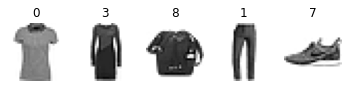

In [59]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [73]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [74]:
standardization = Standardization(input_shape=[28,28])
# input_shape acts to keras.layers.Layer's __init__ method
sample_data = train_set.map(lambda name, label: name)
sample_datas = np.concatenate(list(sample_data.as_numpy_iterator()), #batchごとにnumpy arrayを返す
                             axis=0).astype(np.float32) #除算はfloat限定, axis=0はすべてのbatchを結合して、
                                                     # batch化自体を消した新しいlistを作る

In [75]:
standardization.adapt(sample_datas)
# .as_numpy_iteratorはbatchごとにnumpy arrayとして取得してイテレーションを行う

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [76]:
from datetime import datetime

tensorboard_cb = tf.keras.callbacks.TensorBoard(
     histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=10, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4462 - accuracy: 0.8421 - val_loss: 0.3989 - val_accuracy: 0.8576
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3324 - accuracy: 0.8788 - val_loss: 0.3363 - val_accuracy: 0.8788
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2956 - accuracy: 0.8911 - val_loss: 0.3356 - val_accuracy: 0.8836
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2704 - accuracy: 0.8998 - val_loss: 0.3473 - val_accuracy: 0.8828
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2475 - accuracy: 0.9081 - val_loss: 0.3375 - val_accuracy: 0.8868
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2331 - accuracy: 0.9115 - val_loss: 0.3457 - val_accuracy: 0.8860
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2156 - accuracy: 0.9217 - val_loss: 0.3603 - val_accuracy: